In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import cv2
import scipy

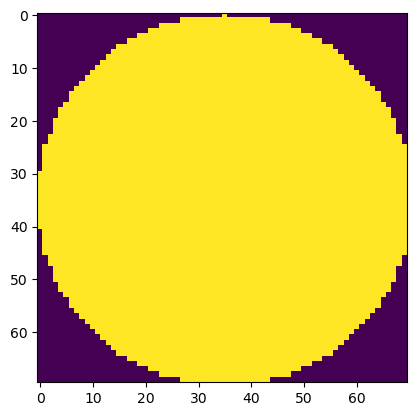

In [2]:
plt.imshow(cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=(70,70)))

In [10]:
def main(filename: str, out_file: str, radius: int):
    with rio.open(filename) as src:
        meta = src.meta.copy()
        transform = src.transform
        arr = src.read(1)
        orig_crs = src.crs
    # km per degree near the ecuator. At high lats this will bite us in the ass
    # The issue here is that the kernel size should vary depending on the raster latitude and proj
    # for now we will asume that the error for high lat rasters is ok but we should explore a fix.
    # TODO: check if crs is geografic and transform to meters

    y_size_km = -transform[4] * 111  # 1 deg ~~ 111 km at ecuator
    radius_in_pixels = int(radius // y_size_km)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=(radius_in_pixels, radius_in_pixels))
    
    # apply the buffer using opencv filter function. 
    # It calculates the cross-croletation instead of the convolution but
    # since we are using a simetric kernel it does not matter.
    # Also it is 100x faster than the scipy convolve ¯\_(ツ)_/¯
    res_buff = cv2.filter2D(arr, ddepth=-1, kernel=kernel) / np.sum(kernel)

    with rio.open(out_file, "w", **meta) as dest:
        dest.write(res_buff[np.newaxis, :])

In [9]:
!gdal_calc.py --calc "(A>19)*0.077847" --format GTiff --type Float32 --NoDataValue 0.0 -A "../../../../Hansen_GFC-2020-v1.8_lossyear_20S_060W.tif" --outfile  "../../../../Hansen_GFC-2020-v1.8_lossyear_20S_060W_ha.tif"
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -r sum -tr 0.0833333333333286 0.0833333333333286 -multi -of GTiff -wo NUM_THREADS=ALL_CPUS "../../../../Hansen_GFC-2020-v1.8_lossyear_20S_060W_ha.tif" "../../../../Hansen_GFC-2020-v1.8_lossyear_20S_060W_10km.tif"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 

In [12]:
%%timeit
main("../../../../Hansen_GFC-2020-v1.8_lossyear_20S_060W_10km.tif",
     "../../../../Hansen_GFC-2020-v1.8_lossyear_20S_060W_10km_buff.tif", 50)

2.97 ms ± 47.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
filename = "../../../../Hansen_GFC-2020-v1.8_lossyear_20S_060W_10km.tif"
with rio.open(filename) as src:
    meta = src.meta.copy()
    transform = src.transform
    arr = src.read(1)
    orig_crs = src.crs
# km per degree near the ecuator. At high lats this will bite us in the ass
# The issue here is that the kernel size should vary depending on the raster latitude and proj
# for now we will asume that the error for high lat rasters is ok but we should explore a fix.
# TODO: check if crs is geografic and transform to meters

y_size_km = -transform[4] * 111  # 1 deg ~~ 111 km at ecuator
radius_in_pixels = int(50 // y_size_km)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=(radius_in_pixels, radius_in_pixels))

# apply the buffer using opencv filter function. 
# It calculates the cross-croletation instead of the convolution but
# since we are using a simetric kernel it does not matter.
# Also it is 100x faster than the scipy convolve ¯\_(ツ)_/¯
res_buff = cv2.filter2D(arr, ddepth=-1, kernel=kernel) / np.sum(kernel)


In [17]:
-transform[4]

0.0833333333333286

In [20]:
orig_crs.is_geographic

True

In [67]:
k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=(100,100))

res = focal_mean("../../../../SpeciesRichness_IDN_2021-01-01-2022-01-01.tif", k, "../../../../ktest_200.tig")

In [68]:
src = rio.open("../../../../SpeciesRichness_IDN_2021-01-01-2022-01-01.tif")
data = src.read(1)


In [80]:
%%time
result_fm = scipy.ndimage.convolve(data, weights=k) / k.size

CPU times: user 6.9 s, sys: 274 ms, total: 7.18 s
Wall time: 7.26 s


In [83]:
%%time
res_cv = cv2.filter2D(data, ddepth=-1, kernel=k) / np.sum(k)

CPU times: user 37.5 ms, sys: 3.9 ms, total: 41.4 ms
Wall time: 42.2 ms


In [84]:
np.sum(k)

7941

In [85]:
k.size

10000

In [71]:
profile = src.profile

In [72]:
with rio.open("../../../../ktest_200_cv.tif","w", **profile) as dst:
    dst.write(res_cv[np.newaxis,:])

with rio.open("../../../../ktest_200.tif", "w", **profile) as dst:
    dst.write(res[np.newaxis,:])

In [73]:
profile

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 793, 'height': 852, 'count': 1, 'crs': None, 'transform': Affine(0.004491672803571973, 0.0, 94.91802968508276,
       0.0, -0.004480428481260716, 5.963450308558013), 'tiled': False, 'interleave': 'band'}

In [53]:
gt = src.transform

In [62]:
y_size_km = -gt[4]*111

In [66]:
50 // y_size_km

100.0

In [87]:
crs = rio.crs.CRS.from_epsg(4326)

In [92]:
crs.is_geographic

True

In [93]:
from rasterio.warp import calculate_default_transform, reproject, Resampling


In [ ]:
calculate_default_transform(